# Clean file with modules

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import inverse_mapping_functions as imf
import Siamese_Architecture as SA

import umap.umap_ as umap
import tqdm

plt.rcParams['image.origin'] = 'lower'

BATCH_SIZE = 64

In [2]:
dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc"
dataset = SproutDataset(dataset_path=dataset_path, augmentation_type='double', log_space=False, normalize_intensity=True)
dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True)

In [3]:
# checkpoint = "C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\Individual project\SPICE_DeepLearning\\SimSiam_miniDataset_Training_64_Contrastive\kyu6raoh\checkpoints\epoch=2-step=10980.ckpt"
# model = SA.SimSiam.load_from_checkpoint(checkpoint)  # Continue epoch 3

model = SA.SimSiam(output_dim=64, backbone_output_dim=128, hidden_layer_dim=128)

#wandb_logger = WandbLogger(project="feb11Dataset_64_doubleAug", log_model=True)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
# trainer = pl.Trainer(max_epochs=15, devices=1, accelerator=accelerator)#, logger=wandb_logger)
# trainer.fit(model=model, train_dataloaders=dataloader)

In [5]:
# checkpoint = "C:\\Users\\tania\Documents\CU Boulder\CU Alpine\models_ckpts\double_epoch=4-step=45750.ckpt"
dataset_none = SproutDataset(dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", augmentation_type=None)
# outputs = SA.run_model(checkpoint, dataset_none)

In [ ]:
# import tqdm
# model.eval()
# outputs = []
# with torch.no_grad():  # Disable gradient computation for inference
#     for i in tqdm.tqdm(range (dataset_none.__len__())):
#         spec = dataset_none.__getitem__(i).unsqueeze(0)
#         # Move tensor to the same device as the model
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         model = model.to(device)
#         spec = spec.to(device)

#         outputs.append(model(spec)[0].cpu().numpy())

# stacked_outputs = np.stack(outputs).squeeze()
# stacked_outputs.shape
# np.save('saved_outputs//stacked_outputs_double64_Feb23_normspec_15epochs.npy', stacked_outputs)

100%|██████████| 117120/117120 [03:58<00:00, 491.25it/s]


In [6]:
# stacked_outputs = np.load('saved_outputs//stacked_outputs_double64_minidata_21Feb_01-5gain.npy')
stacked_outputs = np.load('saved_outputs//stacked_outputs_double64_Feb23_normspec_15epochs.npy')

### Test clustering with various param

In [20]:
for x in tqdm.tqdm([10, 20, 30]):
    for y in [2, 5, 10]:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean') #<=> cosine?
        clusterer.fit(stacked_outputs)
        labels = clusterer.labels_
        np.save(f'saved_outputs//labels_double_normspec_15epochs_Feb23_minclus{x}_minsamp{y}.npy', labels)

100%|██████████| 3/3 [1:22:56<00:00, 1658.85s/it]


Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8]
Unique Clusters: [-1  0  1  2  3  4  5  6]


Text(0.5, 0.98, 'norm_15epochs_Feb23_minclus_double')

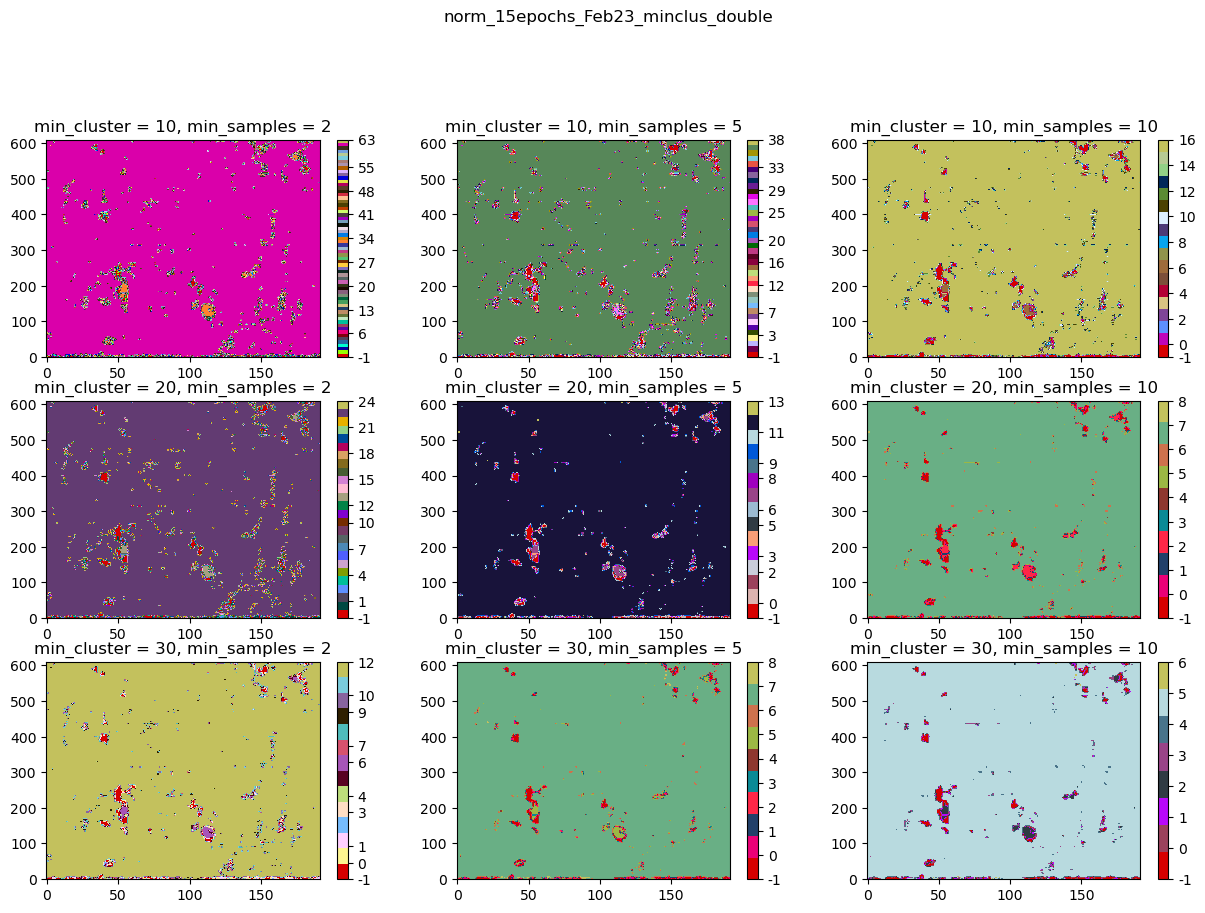

In [6]:
c=0
plt.figure(figsize=(15,13))
for x in [10, 20, 30]:
    for y in [2, 5, 10]:
        c+=1
        plt.subplot(4,3,c)
        # labels = np.load(f'saved_outputs//double_4apr_Feb23_minclus{x}_minsamp{y}.npy')
        labels = np.load(f'saved_outputs//labels_double_normspec_15epochs_Feb23_minclus{x}_minsamp{y}.npy')
        imf.map_clusters(labels, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", selected_clusters=None)
        
        plt.title(f"min_cluster = {x}, min_samples = {y}")
plt.suptitle('norm_15epochs_Feb23_minclus_double')

### Plot average spectra for a single cluster

In [8]:
x,y = (30,10)
labels = np.load(f'saved_outputs//labels_double_normspec_15epochs_Feb23_minclus{x}_minsamp{y}.npy')

In [11]:
current_labels = labels.reshape(610, 192)
unique_clusters = np.unique(current_labels[~np.isnan(current_labels)])

In [12]:
unique_clusters

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [ ]:
# imf.plot_n_random_spectra_cluster(labels, stacked_outputs, chosen_cluster=1, dataset=dataset_none, nbr_items=len(np.where(labels==1)[0]), plot_on_map=False, log_scale=False,
#                                   dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

for i in unique_clusters:
    av_spectra = imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=i, dataset=dataset_none, log_scale=False,
                                  dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

-------------------------------------------------------------------------------

In [7]:
# # embedding_L2 = stacked_outputs / np.linalg.norm(stacked_outputs, ord=2)
# clusterer = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=.5, metric='euclidean')
# clusterer.fit(stacked_outputs)
# labels = clusterer.labels_
# np.save('saved_outputs//clustered_outputs_double64_minidata_minclus10_minsamp5_eps05.npy', labels)

In [ ]:
# clusterer = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=15, min_samples=5, cluster_selection_epsilon=.5, metric='euclidean')
# clusterer.fit(stacked_outputs)
# labels = clusterer.labels_
# np.save('saved_outputs//clustered_outputs_double64_minidata_minclus15_minsamp5_eps05.npy', labels)

In [8]:
# labels = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus10_minsamp5_eps05.npy') 
# imf.map_clusters(labels, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

In [ ]:
plt.hist(labels, bins=np.arange(-1,np.max(labels)+2)-0.5, density=True, range=(-2,2)), plt.yscale('log');

## UMAP

In [ ]:
# reducer = umap.UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42)
# projected_data = reducer.fit_transform(stacked_outputs)
# np.save('saved_outputs//umap_data_64dou_minidataFeb11_neig30_dist001_10_2.npy', projected_data)

# # projected_data = np.load('saved_outputs//umap_data_64dou_fulldata_neig15_dist01.npy')
# # stacked_outputs = np.load('saved_outputs//stacked_outputs_double64_fulldata.npy')
# # labels = np.load('saved_outputs//clustered_outputs_double64_fulldata_minclus30_minsamp30.npy')
# projected_data = np.load('saved_outputs//umap_data_64dou_minidataFeb11_neig30_dist001_10_2.npy')

In [ ]:
from matplotlib.colors import Normalize

In [ ]:
labels = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus5_minsamp2_eps05.npy') 

In [ ]:
target_clusters = [0]  # List of cluster labels to plot
selected_points = projected_data[np.isin(labels, target_clusters)]
selected_labels = labels[np.isin(labels, target_clusters)]
norm = Normalize(vmin=labels.min(), vmax=labels.max())

plt.figure(figsize=(10, 6))
plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='tab20', norm=norm, s=3)
plt.title(f"Scatter Plot for Clusters {target_clusters}\nn_neighbors=15, min_dist=0.1\nmin_cluster_size=50, min_samples=5")
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(10, 14))
plt.subplot(211)
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='tab20', s=1)
plt.colorbar()
plt.title('UMAP Projection to 2D - double augmentation')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.subplot(212)
plt.hist2d(projected_data[:, 0], projected_data[:, 1], bins=200)
plt.colorbar()
plt.grid(True)
plt.title('Density histogram')
plt.show()

In [ ]:
labels01 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps0point1.npy')
labels1 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps1.npy') 
labels05 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps0point5.npy')
labels0 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps0.npy')
labels2 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps2.npy')
labels10 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps10.npy')

In [ ]:
print('0.5')
imf.map_clusters(labels05, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('0.1')
imf.map_clusters(labels01, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('1')
imf.map_clusters(labels1, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('0')
imf.map_clusters(labels0, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('2')
imf.map_clusters(labels2, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('10')
imf.map_clusters(labels10, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

solo_L2_spice-n-ras_20230211T153421_V22_167772557-000.fits
(40, 610, 192)


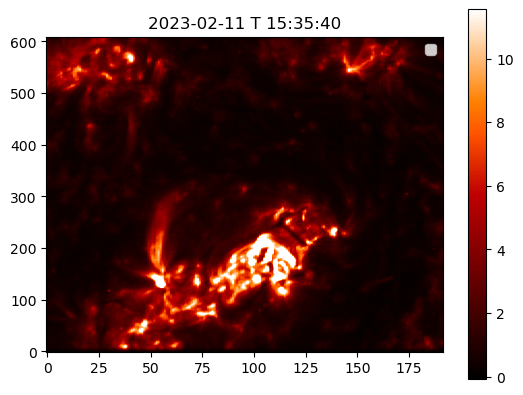

In [4]:
imf.map_item_map(item_nbr=9790, dataset="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", plot=False, title='2023-02-11 T 15:35:40')